1. created new tables for keyword posts and comments (not to skew)

In [5]:
# fetchers/fetch_posts_keyword.py

import praw
import pandas as pd
from datetime import datetime, timezone
from time import time
from config import REDDIT_CREDENTIALS
from utils.paths import project_path
from utils.db_connection import get_db_connection

# === CONFIG ===
MAX_POSTS = 1000
SUBREDDITS_CSV_PATH = project_path / 'data/wgu_subreddits.csv'
COURSE_CODES_CSV_PATH = project_path / 'data/output/reddit_top_20_mentioned_courses.csv'

reddit = praw.Reddit(
    client_id=REDDIT_CREDENTIALS['client_id'],
    client_secret=REDDIT_CREDENTIALS['client_secret'],
    user_agent=REDDIT_CREDENTIALS['user_agent'],
    username=REDDIT_CREDENTIALS['username'],
    password=REDDIT_CREDENTIALS['password']
)


def load_subreddits(csv_path):
    df = pd.read_csv(csv_path, header=None)
    return df[0].dropna().unique().tolist()


def load_course_codes(csv_path):
    df = pd.read_csv(csv_path)
    return df['Course Code'].dropna().unique().tolist()


def normalize_subreddit_id(subreddit_id):
    return subreddit_id.removeprefix('t5_')


def fetch_posts_by_keyword():
    start_time = time()
    fetched_total = 0
    failures = 0
    new_posts = []

    subreddits = load_subreddits(SUBREDDITS_CSV_PATH)
    course_codes = load_course_codes(COURSE_CODES_CSV_PATH)
    conn = get_db_connection()
    cursor = conn.cursor()

    for course_code in course_codes:
        print(f"\nFetching keyword  Course: [{course_code}]")
        for subreddit_name in subreddits:
            try:
                subreddit = reddit.subreddit(subreddit_name)
                subreddit_id = normalize_subreddit_id(subreddit.id)

                query = course_code
                count = 0

                for post in subreddit.search(query, sort='new', limit=MAX_POSTS):
                    try:
                        cursor.execute('''
                            INSERT INTO posts_keyword (
                                post_id, subreddit_id, username, title, selftext, created_utc,
                                edited_utc, score, upvote_ratio, is_promotional, is_removed,
                                is_deleted, flair, post_type, num_comments, url, permalink, search_terms, captured_at
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            post.id,
                            subreddit_id,
                            post.author.name if post.author else None,
                            post.title,
                            post.selftext,
                            int(post.created_utc),
                            int(post.edited) if post.edited else None,
                            post.score,
                            post.upvote_ratio,
                            0,
                            int(post.removed_by_category is not None),
                            int(post.author is None),
                            post.link_flair_text,
                            'text' if post.is_self else 'image' if post.url.endswith(
                                ('.jpg', '.png', '.gif')) else 'video' if post.is_video else 'link',
                            post.num_comments,
                            post.url,
                            post.permalink,
                            query,
                            int(time())
                        ))
                        new_posts.append({
                            "id": post.id,
                            "subreddit_id": subreddit_id,
                            "search_terms": query,
                            "created_utc": int(post.created_utc)
                        })
                        count += 1
                        fetched_total += 1
                    except Exception:
                        pass  # skip duplicates

                conn.commit()

                if count > 0:
                    print(f"r/{subreddit_name} : {count} posts added")

            except Exception as e:
                failures += 1

    conn.close()

    print("\nSummary")
    print(f"Total posts fetched: {fetched_total}")
    print(f"Total failures: {failures}")
    print(f"Duration: {round(time() - start_time, 2)} seconds")

    return {
        "posts_fetched": fetched_total,
        "duration": round(time() - start_time, 2),
        "failures": failures,
        "posts": new_posts
    }


if __name__ == "__main__":
    fetch_posts_by_keyword()


Fetching keyword  Course: [C214]
r/WGU : 159 posts added
r/WGUBusinessManagement : 1 posts added
r/WGUIT : 1 posts added
r/WGU_Accelerators : 1 posts added
r/WGU_Business : 4 posts added
r/WGU_MBA : 231 posts added
r/WGUonline : 1 posts added
r/wguaccounting : 17 posts added

Fetching keyword  Course: [D427]
r/WGU : 222 posts added
r/WGUCyberSecurity : 44 posts added
r/WGUIT : 58 posts added
r/WGU_Accelerators : 10 posts added
r/WGU_CSA : 1 posts added
r/WGU_CompSci : 38 posts added
r/wgu_devs : 35 posts added

Fetching keyword  Course: [C211]
r/WGU : 76 posts added
r/WGU_Business : 3 posts added
r/WGU_MBA : 105 posts added

Fetching keyword  Course: [C213]
r/WGU : 57 posts added
r/WGU_Finance : 1 posts added
r/WGU_MBA : 80 posts added
r/wguaccounting : 5 posts added

Fetching keyword  Course: [C207]
r/WGU : 98 posts added
r/WGUMSHRM : 6 posts added
r/WGU_Business : 1 posts added
r/WGU_MBA : 84 posts added

Fetching keyword  Course: [D335]

Fetching keyword  Course: [D288]
r/WGU : 41 

In [18]:
## fetch single course (my next class)
# fetchers/fetch_posts_keyword.py

import praw
import pandas as pd
from datetime import datetime, timezone
from time import time
from config import REDDIT_CREDENTIALS
from utils.paths import project_path
from utils.db_connection import get_db_connection

# === CONFIG ===
MAX_POSTS = 1000
SUBREDDITS_CSV_PATH = project_path / 'data/wgu_subreddits.csv'

reddit = praw.Reddit(
    client_id=REDDIT_CREDENTIALS['client_id'],
    client_secret=REDDIT_CREDENTIALS['client_secret'],
    user_agent=REDDIT_CREDENTIALS['user_agent'],
    username=REDDIT_CREDENTIALS['username'],
    password=REDDIT_CREDENTIALS['password']
)


def load_subreddits(csv_path):
    df = pd.read_csv(csv_path, header=None)
    return df[0].dropna().unique().tolist()


def normalize_subreddit_id(subreddit_id):
    return subreddit_id.removeprefix('t5_')


def fetch_posts_by_keyword():
    start_time = time()
    fetched_total = 0
    failures = 0
    new_posts = []

    subreddits = load_subreddits(SUBREDDITS_CSV_PATH)
    conn = get_db_connection()
    cursor = conn.cursor()

    query = "D324"

    for subreddit_name in subreddits:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            subreddit_id = normalize_subreddit_id(subreddit.id)

            count = 0

            for post in subreddit.search(query, sort='new', limit=MAX_POSTS):
                try:
                    cursor.execute('''
                        INSERT INTO posts_keyword (
                            post_id, subreddit_id, username, title, selftext, created_utc,
                            edited_utc, score, upvote_ratio, is_promotional, is_removed,
                            is_deleted, flair, post_type, num_comments, url, permalink, search_terms, captured_at
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        post.id,
                        subreddit_id,
                        post.author.name if post.author else None,
                        post.title,
                        post.selftext,
                        int(post.created_utc),
                        int(post.edited) if post.edited else None,
                        post.score,
                        post.upvote_ratio,
                        0,
                        int(post.removed_by_category is not None),
                        int(post.author is None),
                        post.link_flair_text,
                        'text' if post.is_self else 'image' if post.url.endswith(
                            ('.jpg', '.png', '.gif')) else 'video' if post.is_video else 'link',
                        post.num_comments,
                        post.url,
                        post.permalink,
                        query,
                        int(time())
                    ))
                    new_posts.append({
                        "id": post.id,
                        "subreddit_id": subreddit_id,
                        "search_terms": query,
                        "created_utc": int(post.created_utc)
                    })
                    count += 1
                    fetched_total += 1
                except Exception:
                    pass  # skip duplicates

            conn.commit()

            if count > 0:
                print(f"r/{subreddit_name} : {count} posts added")

        except Exception as e:
            failures += 1

    conn.close()

    print("\nSummary")
    print(f"Total posts fetched: {fetched_total}")
    print(f"Total failures: {failures}")
    print(f"Duration: {round(time() - start_time, 2)} seconds")

    return {
        "posts_fetched": fetched_total,
        "duration": round(time() - start_time, 2),
        "failures": failures,
        "posts": new_posts
    }


if __name__ == "__main__":
    fetch_posts_by_keyword()

r/WGU : 58 posts added
r/WGUCyberSecurity : 7 posts added
r/WGUIT : 5 posts added
r/wgu_devs : 9 posts added

Summary
Total posts fetched: 79
Total failures: 2
Duration: 61.23 seconds


In [6]:
# scripts/count_posts_by_course.py

import sqlite3
import pandas as pd
from utils.paths import project_path

DB_PATH = project_path / "db/WGU-Reddit.db"
CSV_PATH = project_path / "data/output/reddit_top_20_mentioned_courses.csv"

df = pd.read_csv(CSV_PATH)
df = df.rename(columns={'Count': 'count_organic'})

conn = sqlite3.connect(DB_PATH)
keyword_counts = []

for code in df['Course Code']:
    count = conn.execute(
        "SELECT COUNT(*) FROM posts_keyword WHERE search_terms = ?", (code,)
    ).fetchone()[0]
    keyword_counts.append(count)

df['count_keyword'] = keyword_counts
print(df)

conn.close()

   Course Code  count_organic  count_keyword
0         C214            298            415
1         D427            252            408
2         C211            216            184
3         C213            191            143
4         C207            189            189
5         D335            161            265
6         D288            149            167
7         D287            144            102
8         D333            139            255
9         D426            136            184
10        D315            130            199
11        C949            127            194
12        D278            120            132
13        C215            119             85
14        C777            114            264
15        D336            110            154
16        D197             92            117
17        D282             89            123
18        D487             85            105
19        D316             85            130


In [7]:
# for some, we got more: for some we got less. let's combine. 

In [23]:
# scripts/export_combined_posts.py

import sqlite3
import pandas as pd
from utils.paths import project_path

DB_PATH = project_path / "db/WGU-Reddit.db"
OUTPUT_PATH = project_path / "data/output/course_keyword_organic_posts"

def export_combined_posts():
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Get all course codes from posts_keyword
    cursor.execute("SELECT DISTINCT search_terms FROM posts_keyword")
    course_codes = sorted(set(row[0] for row in cursor.fetchall()))

    for code in course_codes:
        # Get organic posts that mention the code in title or selftext
        df_organic = pd.read_sql_query(f"""
            SELECT post_id AS 'Post ID',
                   title AS 'Title',
                   selftext AS 'Body',
                   created_utc AS 'Timestamp'
            FROM posts
            WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
        """, conn, params=(code, code))

        # Get keyword posts for this course code
        df_keyword = pd.read_sql_query(f"""
            SELECT post_id AS 'Post ID',
                   title AS 'Title',
                   selftext AS 'Body',
                   created_utc AS 'Timestamp'
            FROM posts_keyword
            WHERE search_terms = ?
        """, conn, params=(code,))

        # Combine, drop duplicates
        df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])

        if not df_combined.empty:
            file_name = f"{code}_combined_posts.csv"
            out_path = OUTPUT_PATH / file_name
            df_combined.to_csv(out_path, index=False)
            print(f"Exported: {file_name} ({len(df_combined)} rows)")

    conn.close()

if __name__ == "__main__":
    export_combined_posts()



Exported: C207_combined_posts.csv (251 rows)
Exported: C211_combined_posts.csv (237 rows)
Exported: C213_combined_posts.csv (207 rows)
Exported: C214_combined_posts.csv (421 rows)
Exported: C215_combined_posts.csv (131 rows)
Exported: C777_combined_posts.csv (293 rows)
Exported: C949_combined_posts.csv (222 rows)
Exported: D197_combined_posts.csv (146 rows)
Exported: D278_combined_posts.csv (172 rows)
Exported: D282_combined_posts.csv (169 rows)
Exported: D287_combined_posts.csv (149 rows)
Exported: D288_combined_posts.csv (188 rows)
Exported: D315_combined_posts.csv (218 rows)
Exported: D316_combined_posts.csv (161 rows)
Exported: D324_combined_posts.csv (105 rows)
Exported: D333_combined_posts.csv (288 rows)
Exported: D335_combined_posts.csv (325 rows)
Exported: D336_combined_posts.csv (198 rows)
Exported: D426_combined_posts.csv (244 rows)
Exported: D427_combined_posts.csv (433 rows)
Exported: D487_combined_posts.csv (108 rows)


In [ ]:
# next_jupyter_cell.py

import pandas as pd
from pathlib import Path
from IPython.display import display

output_path = Path("data/output/course_keyword_organic_posts")
dfs = {}

for file in output_path.glob("*_combined_posts.csv"):
    df = pd.read_csv(file)
    df = df.drop(columns=["Timestamp"])
    df["Title"] = df["Title"].astype(str).str.slice(0, 50)
    df["Body"] = df["Body"].astype(str).str.slice(0, 150)
    dfs[file.stem] = df
    print(f"--- {file.name} ---")
    display(df.head(50))

In [15]:
# character count

import pandas as pd
from pathlib import Path
from IPython.display import display

output_path = Path("data/output/course_keyword_organic_posts")

for file in output_path.glob("*_combined_posts.csv"):
    df = pd.read_csv(file)
    df["Title"] = df["Title"].astype(str)
    df["Body"] = df["Body"].astype(str)
    df["Post Length"] = df["Title"].str.len() + df["Body"].str.len()

    desc = df["Post Length"].describe(percentiles=[0.25, 0.5, 0.75])

    print(f"--- {file.stem} ---")
    print(f"Min: {desc['min']:.0f}")
    print(f"Max: {desc['max']:.0f}")
    print(f"Mean: {desc['mean']:.2f}")
    print(f"25% (Q1): {desc['25%']:.0f}")
    print(f"50% (Median): {desc['50%']:.0f}")
    print(f"75% (Q3): {desc['75%']:.0f}")
    print(f"IQR: {desc['75%'] - desc['25%']:.0f}\n")

--- D426_combined_posts ---
Min: 20
Max: 24013
Mean: 1256.46
25% (Q1): 314
50% (Median): 565
75% (Q3): 1374
IQR: 1060

--- D282_combined_posts ---
Min: 24
Max: 11317
Mean: 1076.25
25% (Q1): 305
50% (Median): 793
75% (Q3): 1543
IQR: 1238

--- C215_combined_posts ---
Min: 21
Max: 34101
Mean: 1515.67
25% (Q1): 188
50% (Median): 372
75% (Q3): 732
IQR: 545

--- C213_combined_posts ---
Min: 14
Max: 34101
Mean: 1353.06
25% (Q1): 186
50% (Median): 360
75% (Q3): 720
IQR: 534

--- D287_combined_posts ---
Min: 14
Max: 29835
Mean: 2337.09
25% (Q1): 453
50% (Median): 910
75% (Q3): 1568
IQR: 1115

--- D315_combined_posts ---
Min: 32
Max: 11317
Mean: 1037.12
25% (Q1): 224
50% (Median): 501
75% (Q3): 1160
IQR: 936

--- D288_combined_posts ---
Min: 12
Max: 29835
Mean: 1815.88
25% (Q1): 348
50% (Median): 718
75% (Q3): 1587
IQR: 1239

--- C211_combined_posts ---
Min: 21
Max: 34101
Mean: 1270.51
25% (Q1): 196
50% (Median): 390
75% (Q3): 701
IQR: 505

--- D335_combined_posts ---
Min: 15
Max: 23637
Mean: 94

## Why 2,000 Characters Works

Stats show 75% of posts are under ~1,500 chars, median under ~800.  
Max lengths (30k+) are rare outliers.  

A 2,000 char cap keeps ~90% of posts intact and trims only a few big ones.  
Good balance: minimal loss, easier storage and display.

In [17]:
# next_jupyter_cell.py

import pandas as pd
from pathlib import Path

output_path = Path("data/output/course_keyword_organic_posts")

for file in output_path.glob("*_combined_posts.csv"):
    df = pd.read_csv(file)
    df["Title"] = df["Title"].astype(str)
    df["Body"] = df["Body"].astype(str)
    df["Post Length"] = df["Title"].str.len() + df["Body"].str.len()

    over_2k = df[df["Post Length"] > 2000]["Post Length"].tolist()
    over_2k_sorted = sorted(over_2k)
    under_2k = len(df) - len(over_2k)

    print(f"--- {file.stem} ---")
    print(f"Posts under 2k: {under_2k}")
    print(f"Posts over 2k: {len(over_2k_sorted)}")
    print(f"Over 2k lengths: {over_2k_sorted}\n")

--- D426_combined_posts ---
Posts under 2k: 211
Posts over 2k: 33
Over 2k lengths: [2029, 2059, 2088, 2104, 2262, 2270, 2330, 2576, 2671, 2679, 2695, 2726, 2878, 3023, 3082, 3131, 3324, 3331, 3460, 3513, 3557, 3763, 4492, 4704, 4956, 5144, 5488, 10536, 10562, 11317, 13524, 13524, 24013]

--- D282_combined_posts ---
Posts under 2k: 148
Posts over 2k: 21
Over 2k lengths: [2029, 2089, 2163, 2197, 2218, 2252, 2262, 2407, 2446, 2451, 2528, 2564, 2574, 2651, 3124, 3243, 3414, 3456, 3681, 6202, 11317]

--- C215_combined_posts ---
Posts under 2k: 118
Posts over 2k: 13
Over 2k lengths: [2032, 2634, 2776, 3586, 6435, 7347, 7828, 11814, 14645, 14754, 16535, 22359, 34101]

--- C213_combined_posts ---
Posts under 2k: 186
Posts over 2k: 21
Over 2k lengths: [2078, 2195, 2244, 2455, 2586, 2634, 2703, 3586, 5723, 6435, 7134, 7347, 7828, 11451, 11814, 14645, 14754, 16356, 16535, 22359, 34101]

--- D287_combined_posts ---
Posts under 2k: 119
Posts over 2k: 30
Over 2k lengths: [2082, 2190, 2197, 2262, 236

Posts found: 105


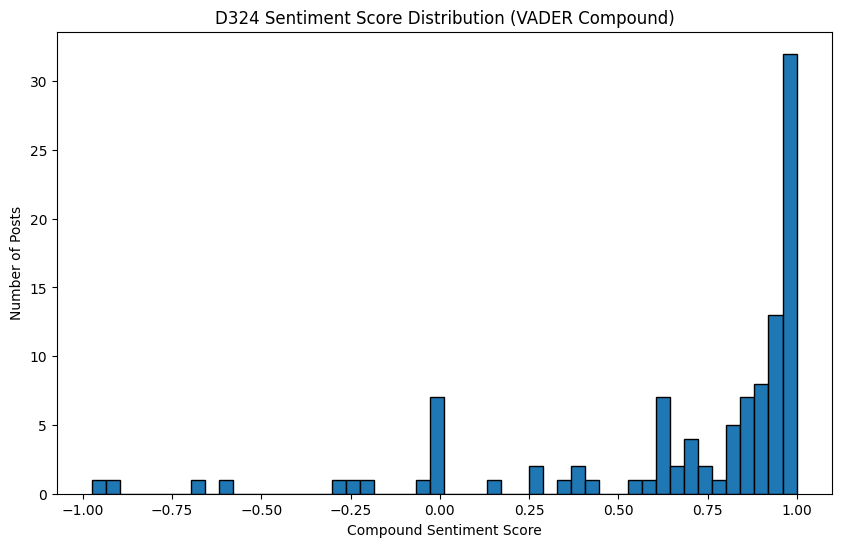

In [33]:
# course_sentiment_pipeline_in_memory.py

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from utils.paths import project_path

# === CONFIG ===
COURSE_CODE = "D324"

# === PATHS ===
DB_PATH = project_path / "db/WGU-Reddit.db"

# === EXPORT ===
conn = sqlite3.connect(DB_PATH)

df_organic = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           title AS 'Title',
           selftext AS 'Body',
           created_utc AS 'Timestamp'
    FROM posts
    WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
""", conn, params=(COURSE_CODE, COURSE_CODE))

df_keyword = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           title AS 'Title',
           selftext AS 'Body',
           created_utc AS 'Timestamp'
    FROM posts_keyword
    WHERE search_terms = ?
""", conn, params=(COURSE_CODE,))

df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])
conn.close()

# === CLEAN ===
df_combined['Title'] = df_combined['Title'].fillna('').str.strip()
df_combined['Body'] = df_combined['Body'].fillna('').str.strip()
df_clean = df_combined[(df_combined['Title'] != '') | (df_combined['Body'] != '')].copy()

# === VADER ===
analyzer = SentimentIntensityAnalyzer()

def get_compound(row):
    text = f"{row['Title']} {row['Body']}"
    return analyzer.polarity_scores(text)['compound']

df_clean['Sentiment'] = df_clean.apply(get_compound, axis=1)

print(f"Posts found: {len(df_clean)}")

# === PLOT ===
plt.figure(figsize=(10, 6))
plt.hist(df_clean['Sentiment'], bins=50, edgecolor='k')
plt.title(f'{COURSE_CODE} Sentiment Score Distribution (VADER Compound)')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Posts')
plt.show()

C214: 421 posts


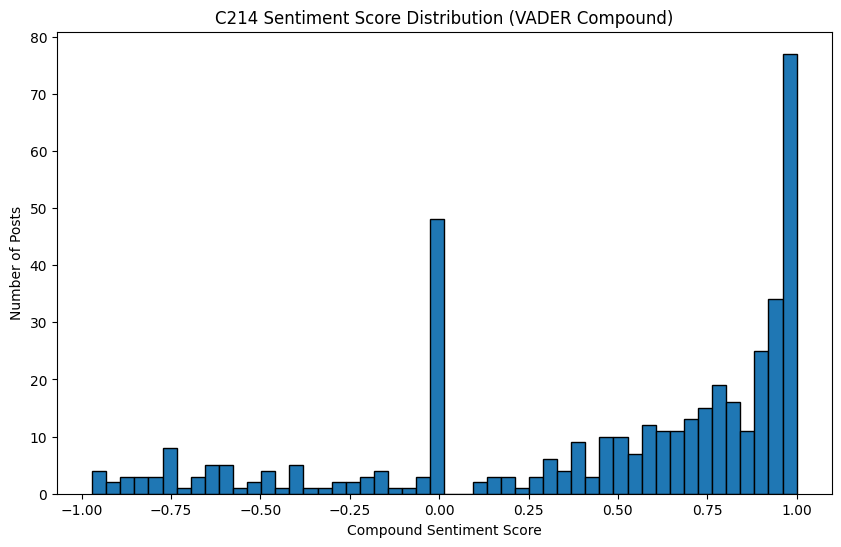

D427: 433 posts


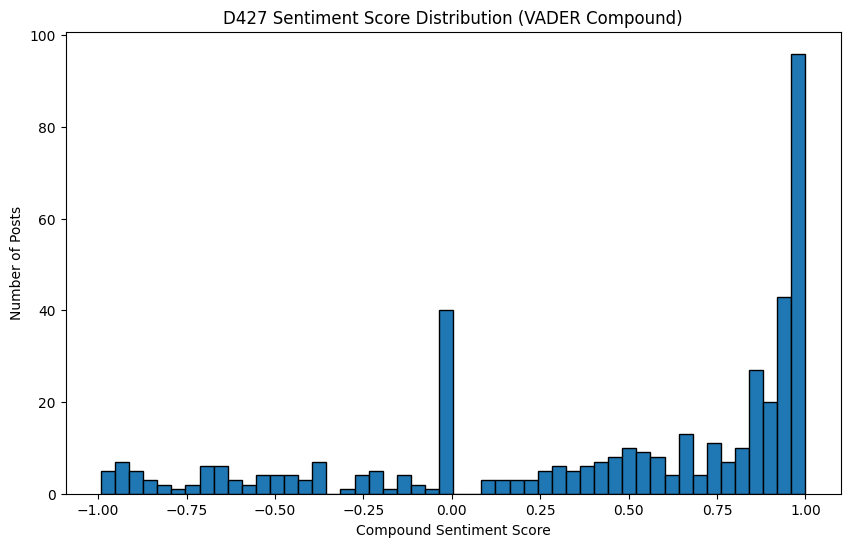

C211: 237 posts


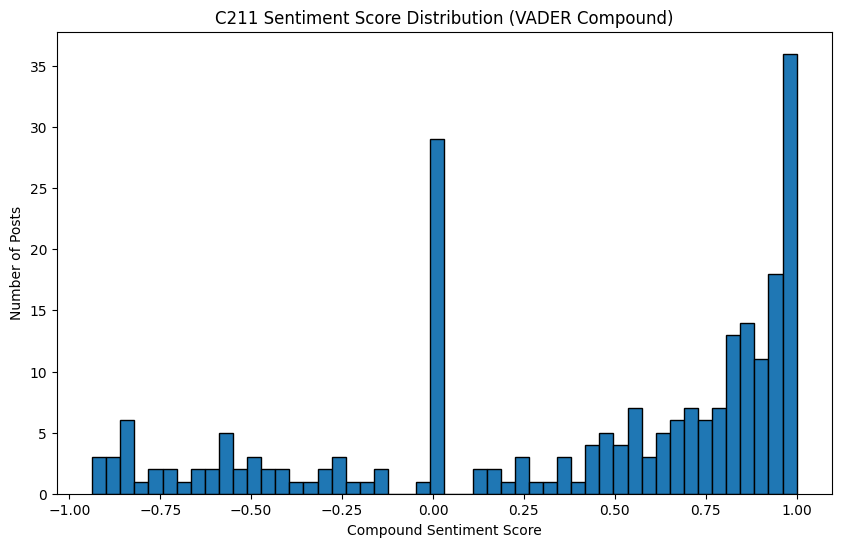

C213: 207 posts


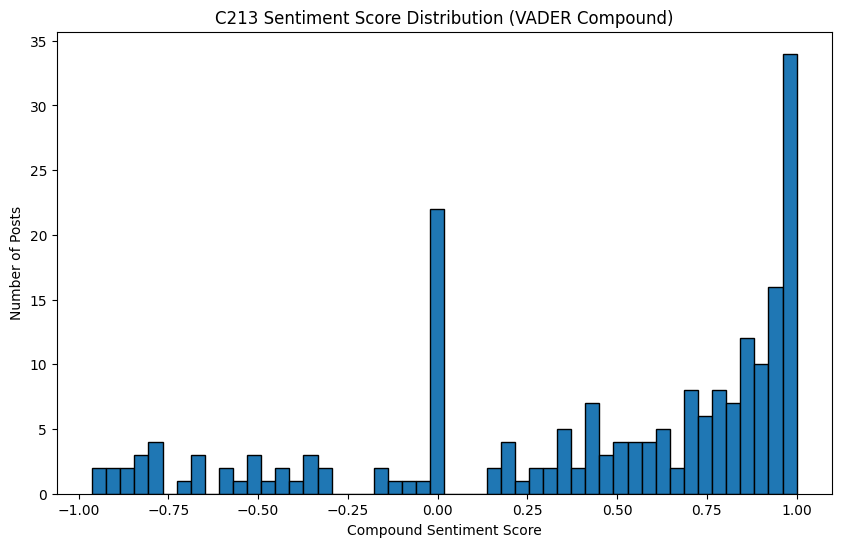

C207: 251 posts


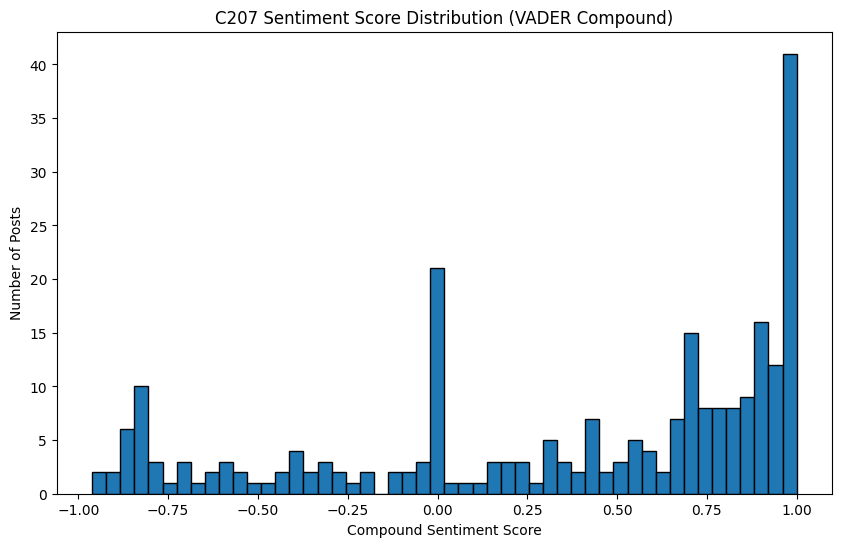

D335: 325 posts


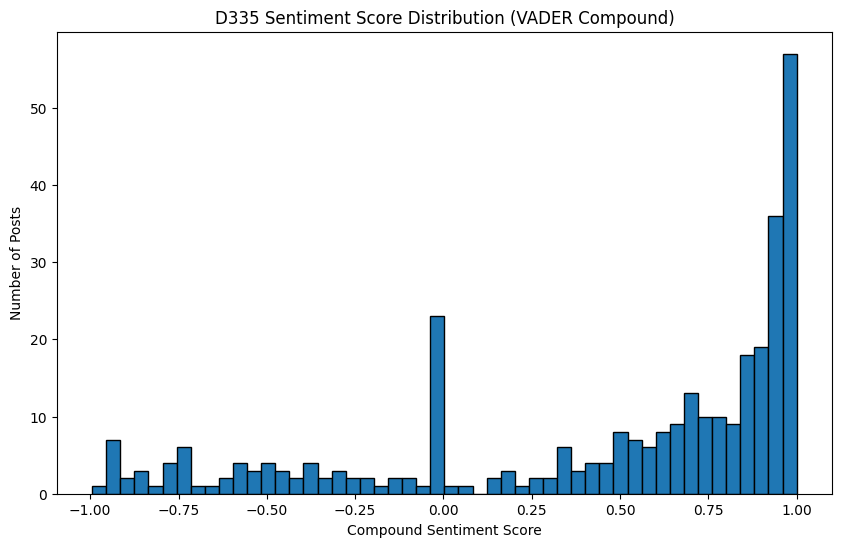

D288: 188 posts


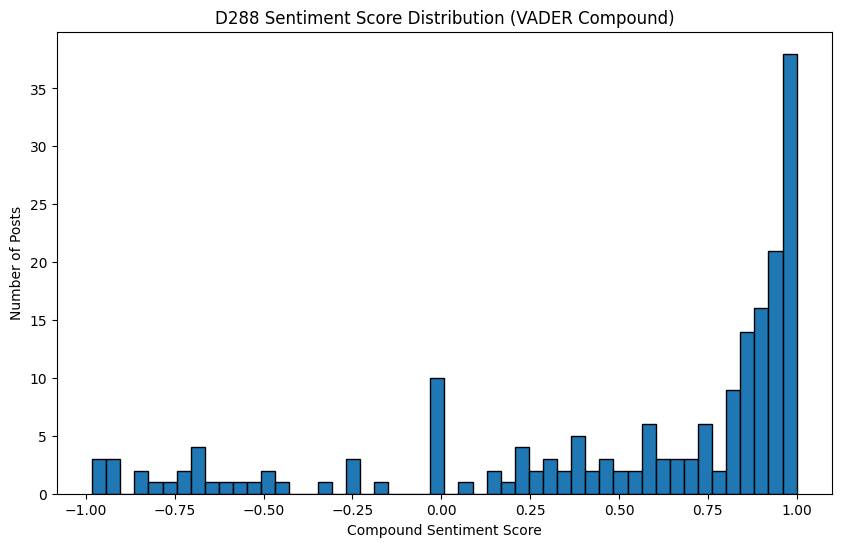

D287: 149 posts


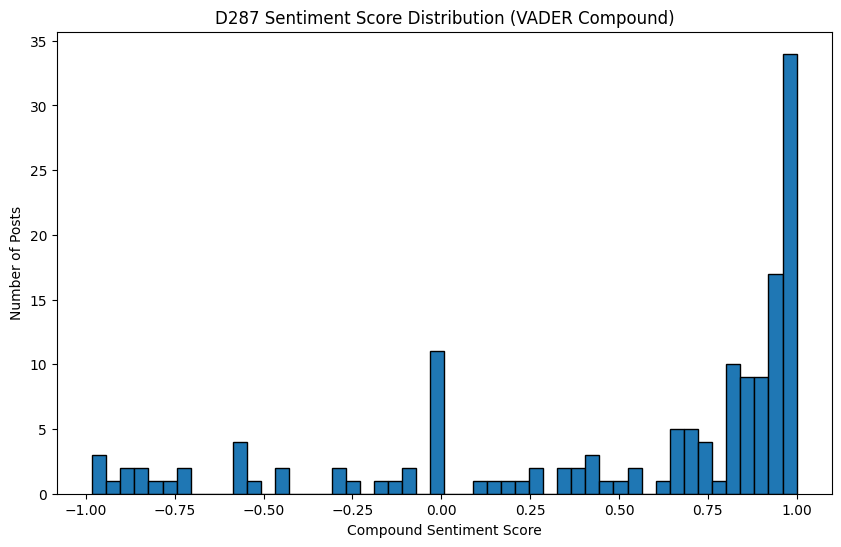

D333: 288 posts


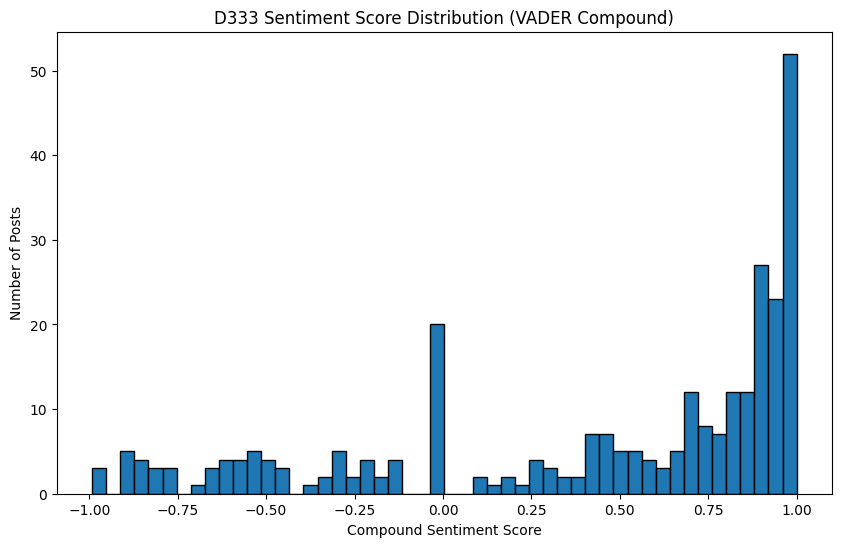

D426: 244 posts


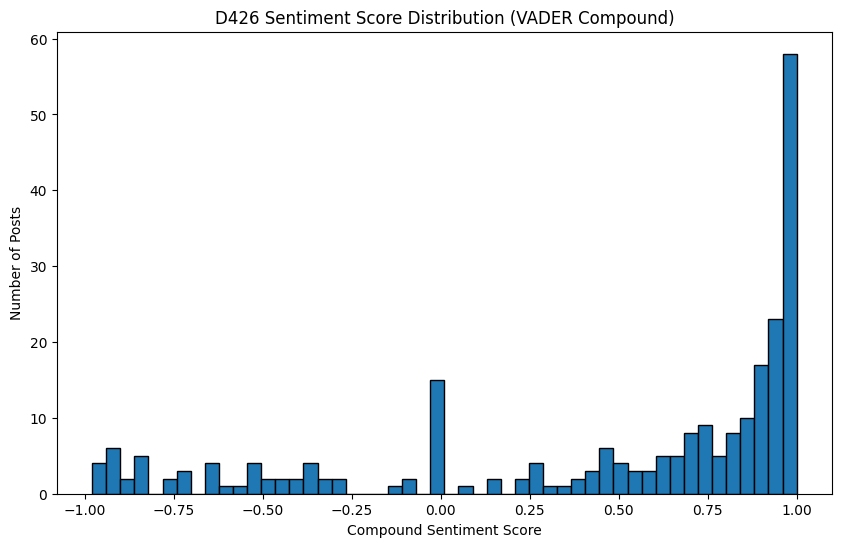

D315: 218 posts


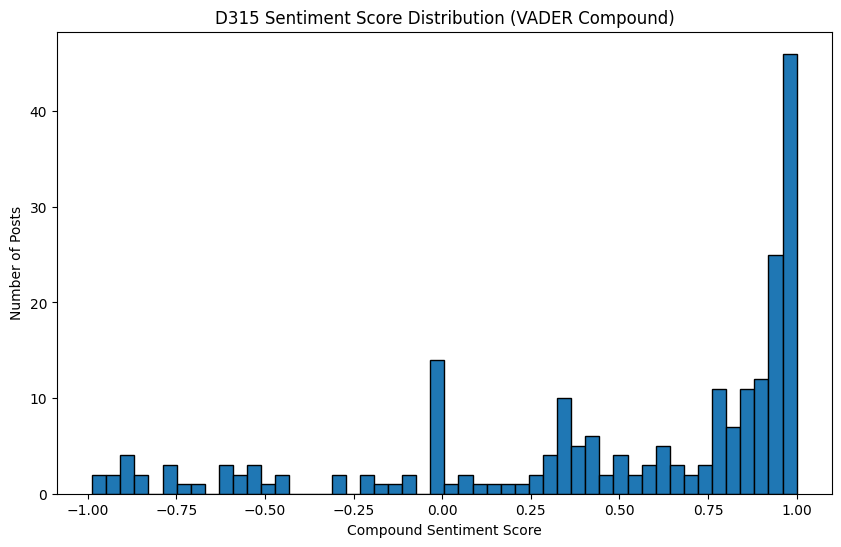

C949: 222 posts


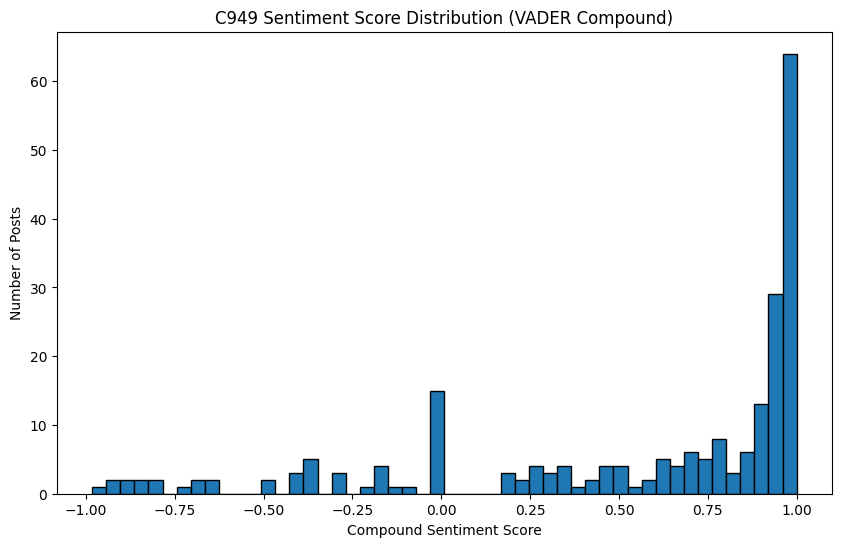

D278: 172 posts


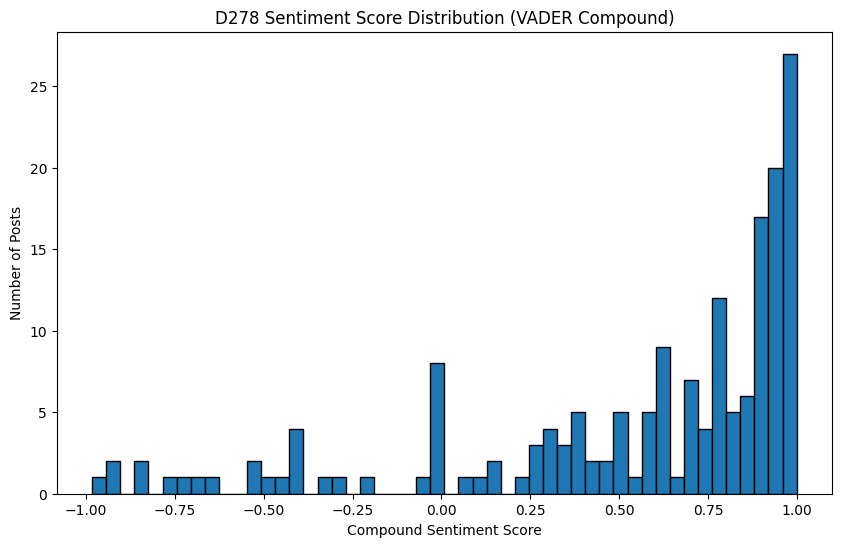

C215: 131 posts


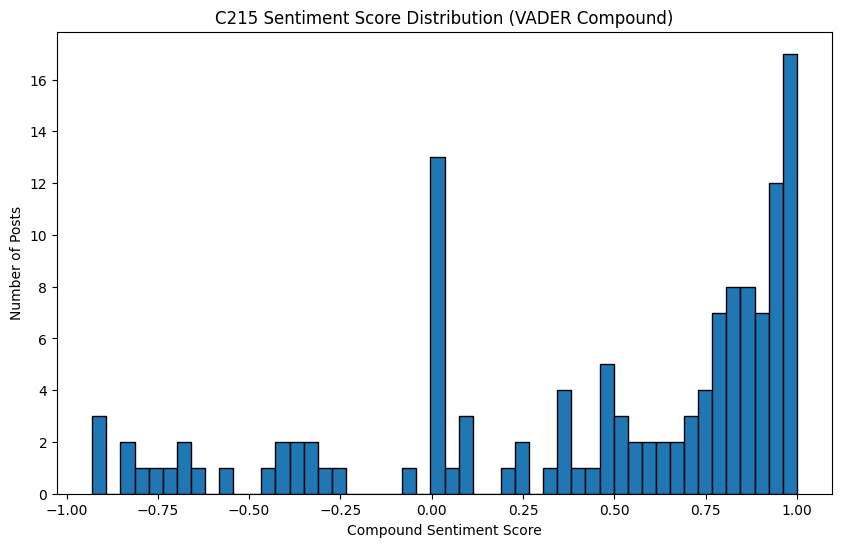

C777: 293 posts


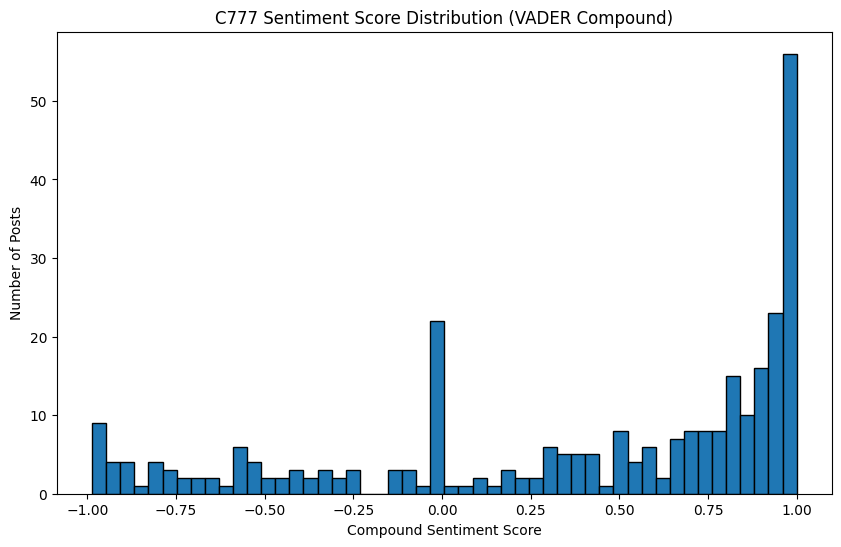

D336: 198 posts


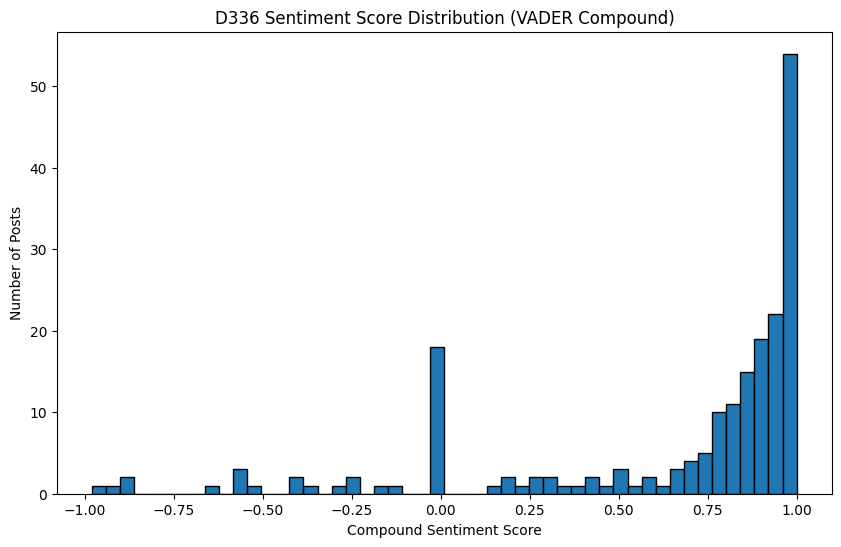

D197: 146 posts


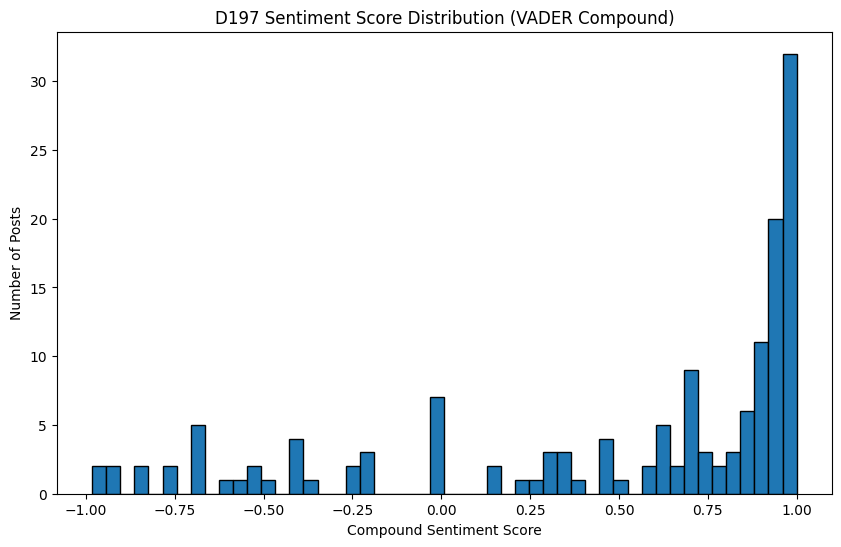

D282: 169 posts


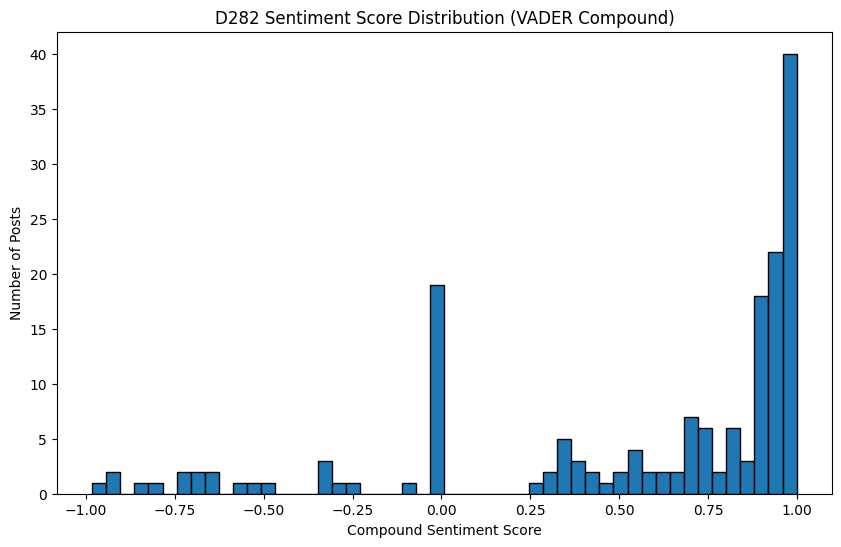

D487: 108 posts


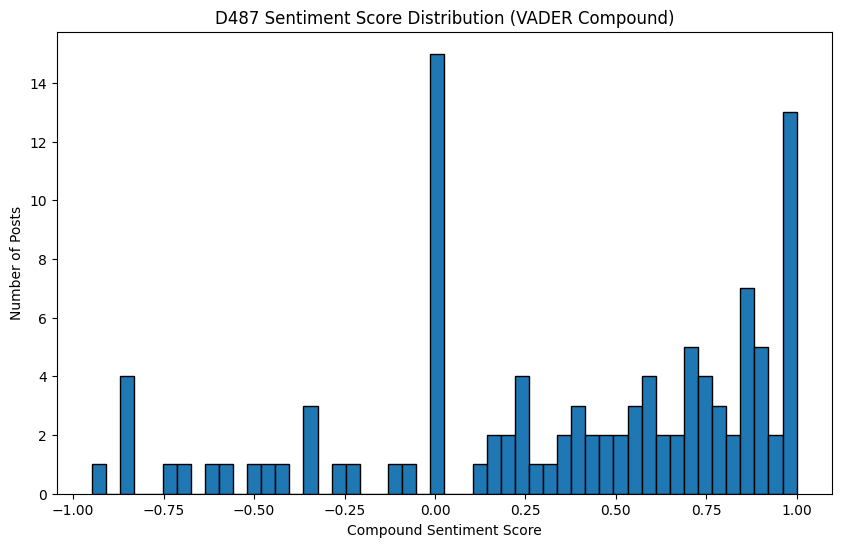

D316: 161 posts


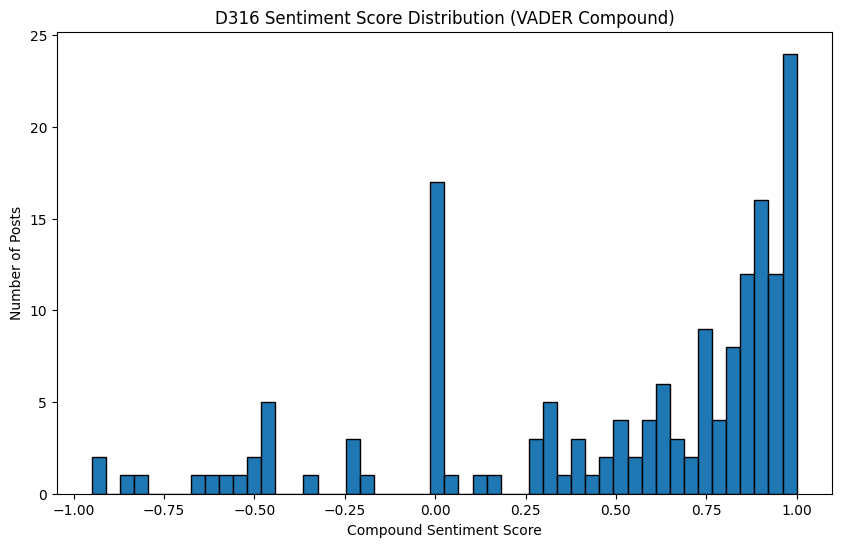

In [34]:
# all_courses_sentiment_pipeline_in_memory.py

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from utils.paths import project_path

# === CONFIG ===
DB_PATH = project_path / "db/WGU-Reddit.db"
COURSES_CSV = "/Users/buddy/Desktop/WGU-Reddit/data/output/reddit_top_20_mentioned_courses.csv"

# === LOAD COURSES ===
df_courses = pd.read_csv(COURSES_CSV)
course_codes = df_courses['Course Code'].tolist()

# === VADER ===
analyzer = SentimentIntensityAnalyzer()

# === LOOP ===
for course_code in course_codes:
    conn = sqlite3.connect(DB_PATH)

    df_organic = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body',
               created_utc AS 'Timestamp'
        FROM posts
        WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
    """, conn, params=(course_code, course_code))

    df_keyword = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body',
               created_utc AS 'Timestamp'
        FROM posts_keyword
        WHERE search_terms = ?
    """, conn, params=(course_code,))

    conn.close()

    df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])
    df_combined['Title'] = df_combined['Title'].fillna('').str.strip()
    df_combined['Body'] = df_combined['Body'].fillna('').str.strip()
    df_clean = df_combined[(df_combined['Title'] != '') | (df_combined['Body'] != '')].copy()

    if df_clean.empty:
        print(f"{course_code}: No posts found.")
        continue

    def get_compound(row):
        text = f"{row['Title']} {row['Body']}"
        return analyzer.polarity_scores(text)['compound']

    df_clean['Sentiment'] = df_clean.apply(get_compound, axis=1)

    print(f"{course_code}: {len(df_clean)} posts")

    plt.figure(figsize=(10, 6))
    plt.hist(df_clean['Sentiment'], bins=50, edgecolor='k')
    plt.title(f'{course_code} Sentiment Score Distribution (VADER Compound)')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Number of Posts')
    plt.show()

D335: 325 posts, min sentiment: -0.9945


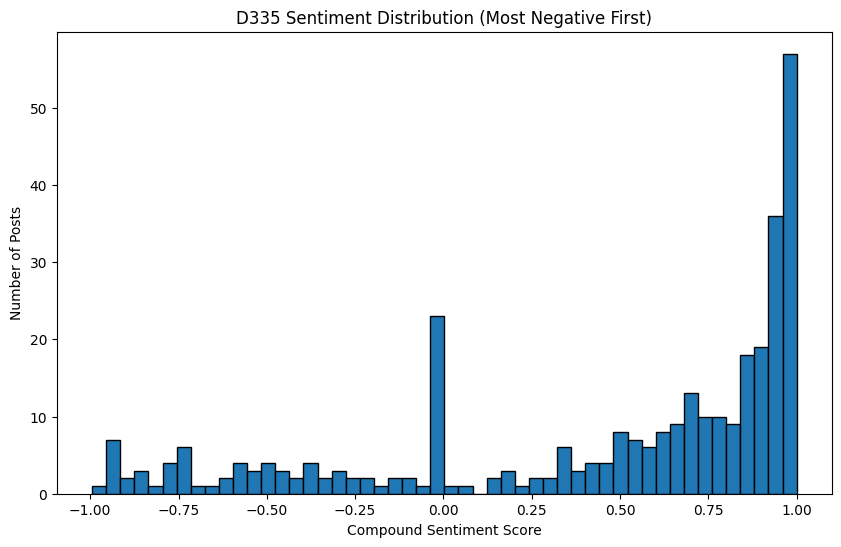

D427: 433 posts, min sentiment: -0.9923


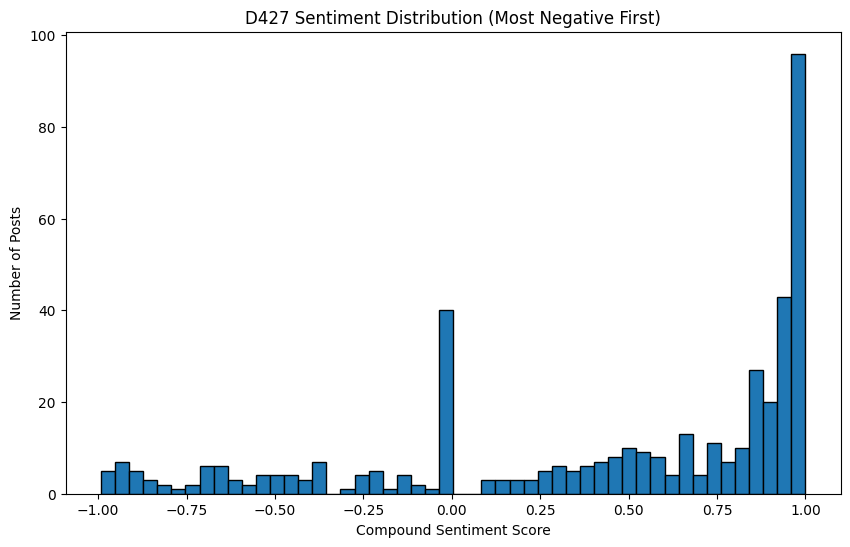

D333: 288 posts, min sentiment: -0.9919


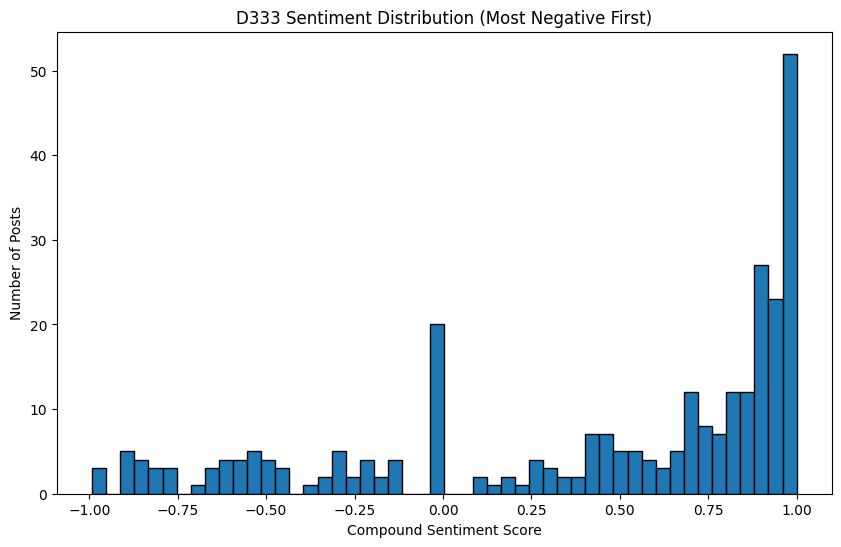

D315: 218 posts, min sentiment: -0.9872


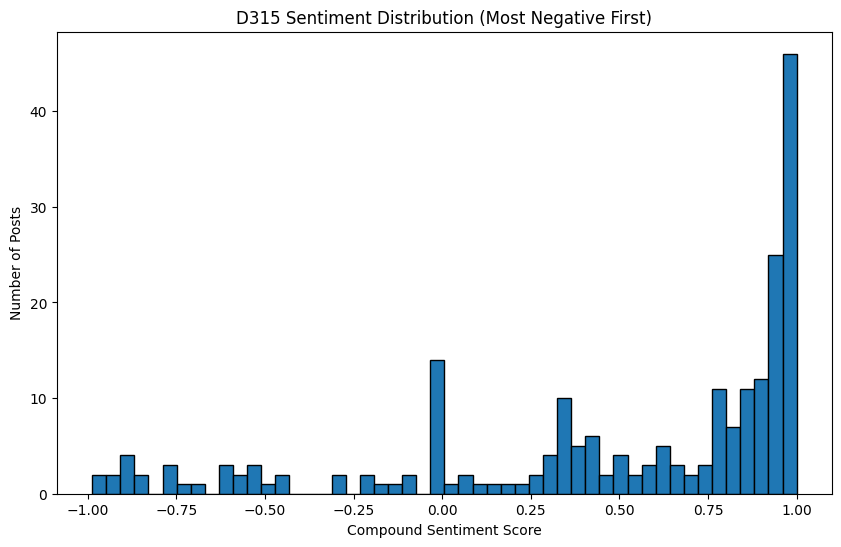

C777: 293 posts, min sentiment: -0.9869


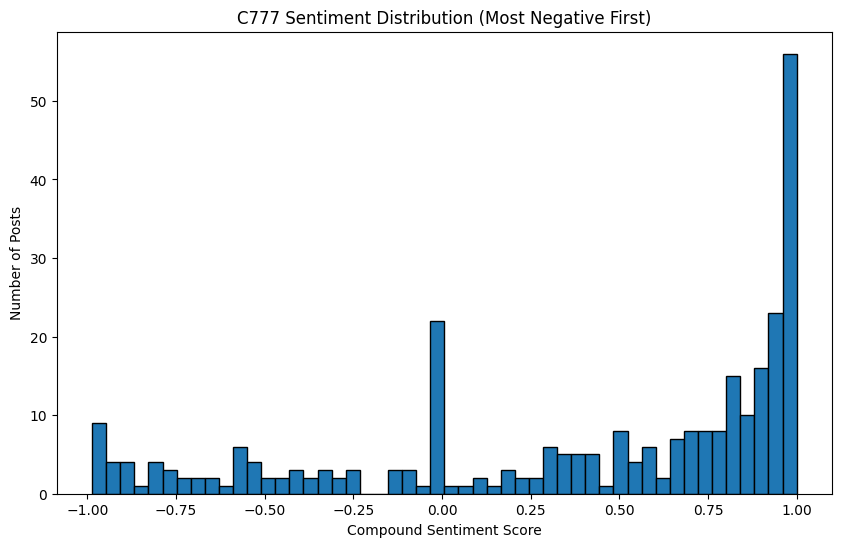

D278: 172 posts, min sentiment: -0.9825


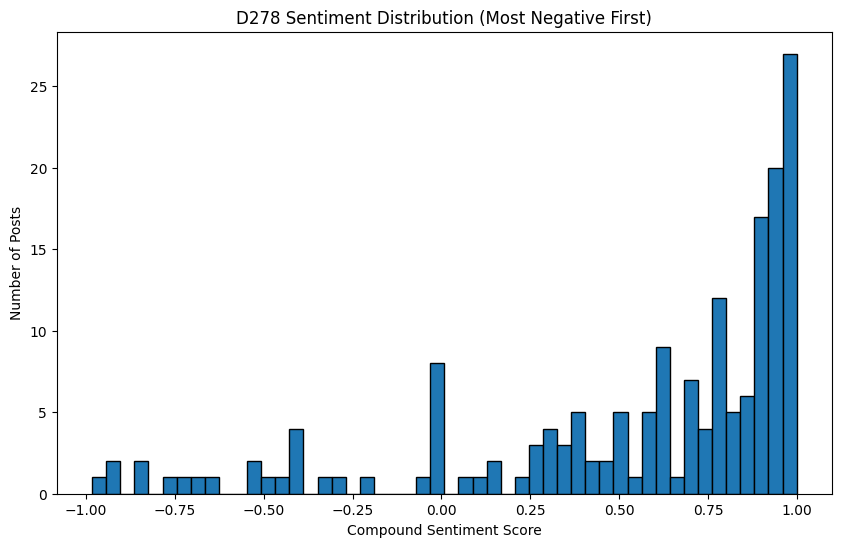

D288: 188 posts, min sentiment: -0.9822


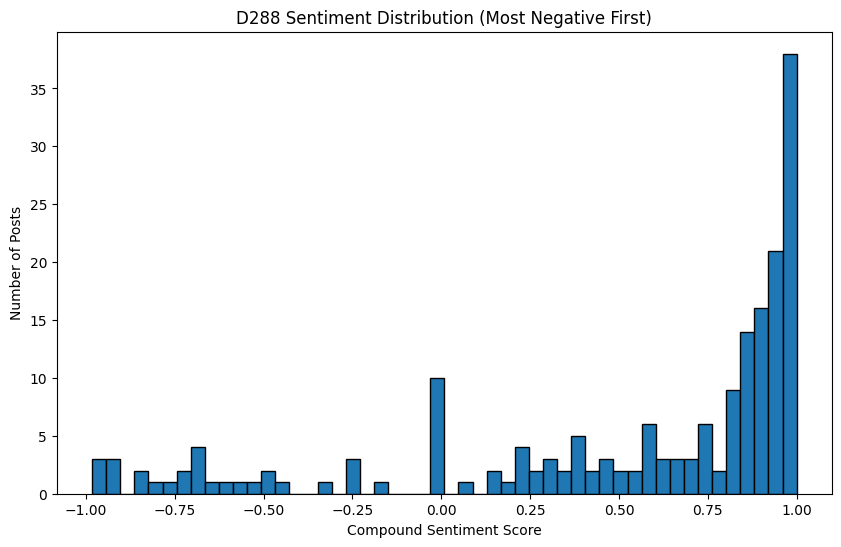

D287: 149 posts, min sentiment: -0.9822


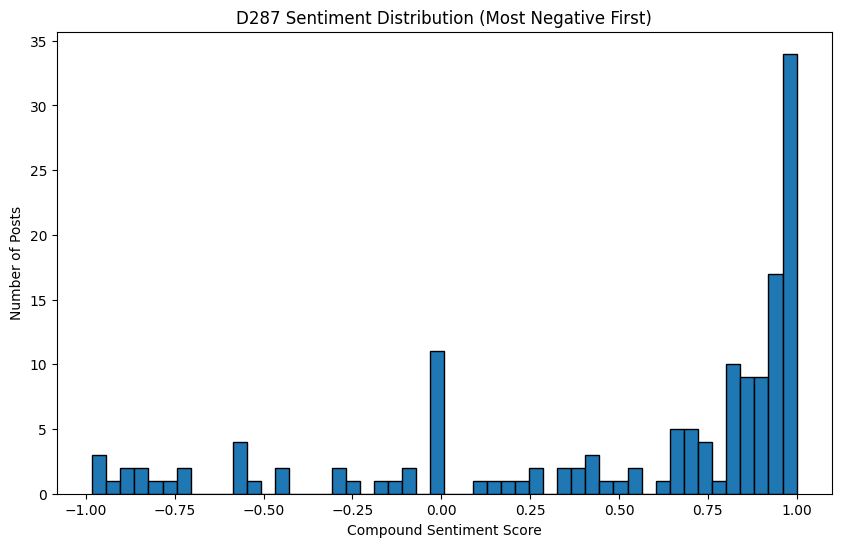

C949: 222 posts, min sentiment: -0.9822


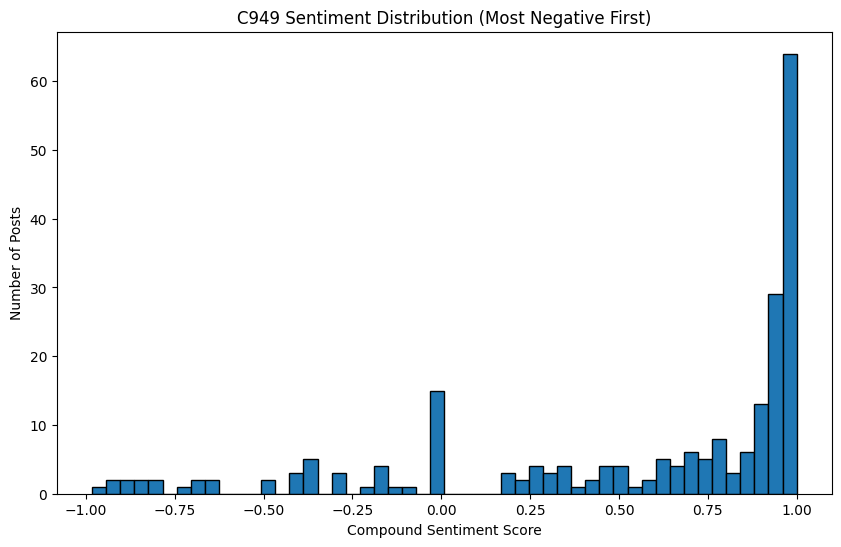

D197: 146 posts, min sentiment: -0.9822


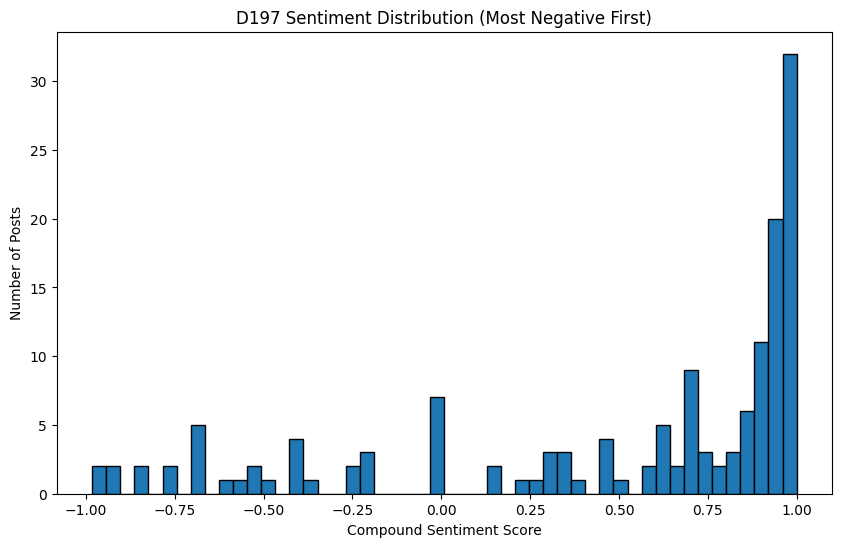

D282: 169 posts, min sentiment: -0.9822


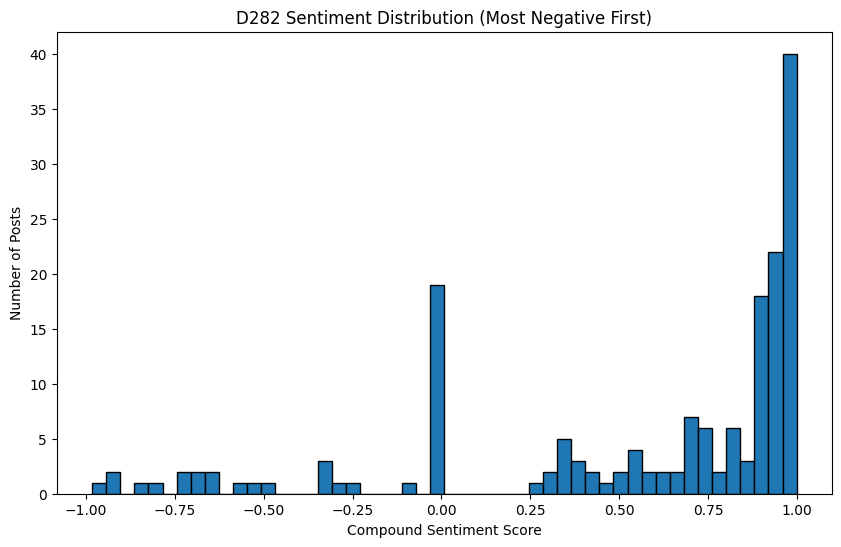

D426: 244 posts, min sentiment: -0.9801


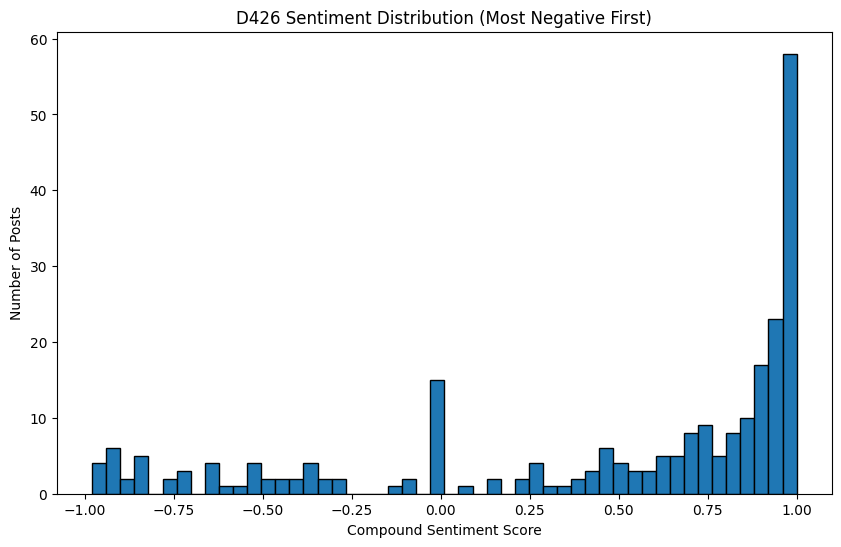

D336: 198 posts, min sentiment: -0.9799


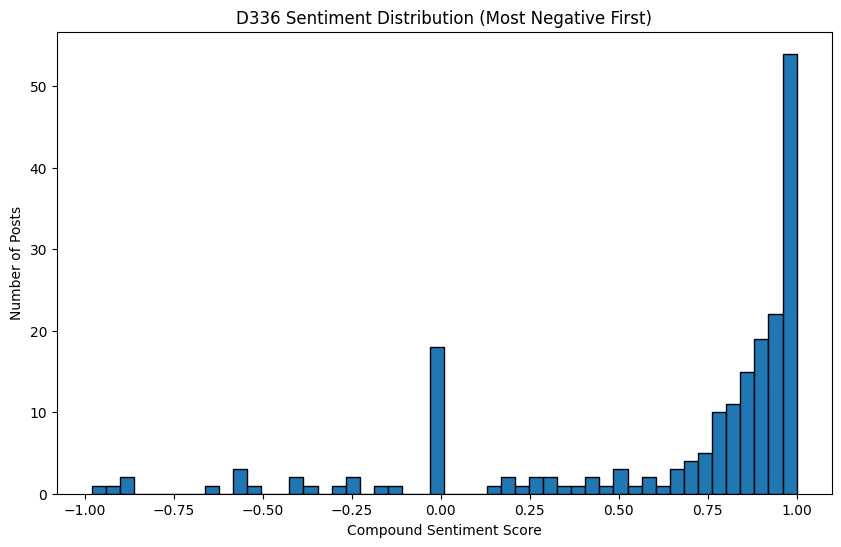

C214: 421 posts, min sentiment: -0.9704


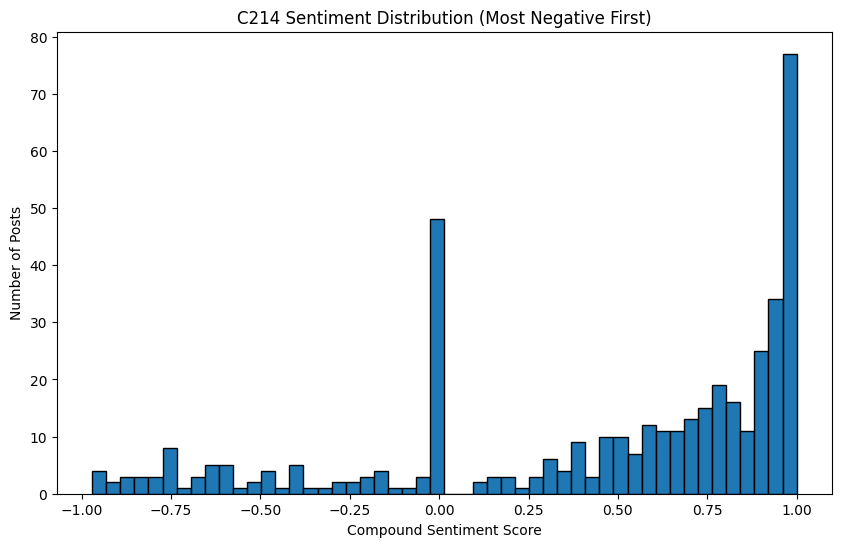

C213: 207 posts, min sentiment: -0.9624


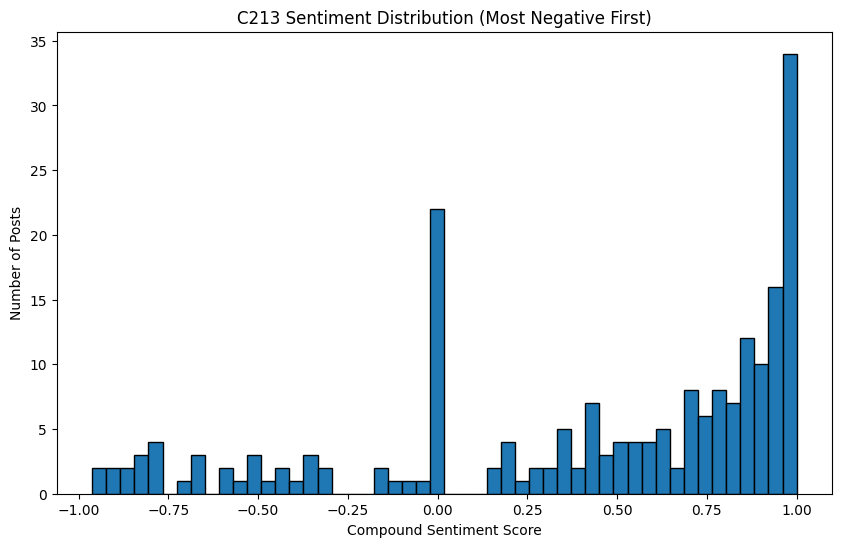

C207: 251 posts, min sentiment: -0.9616


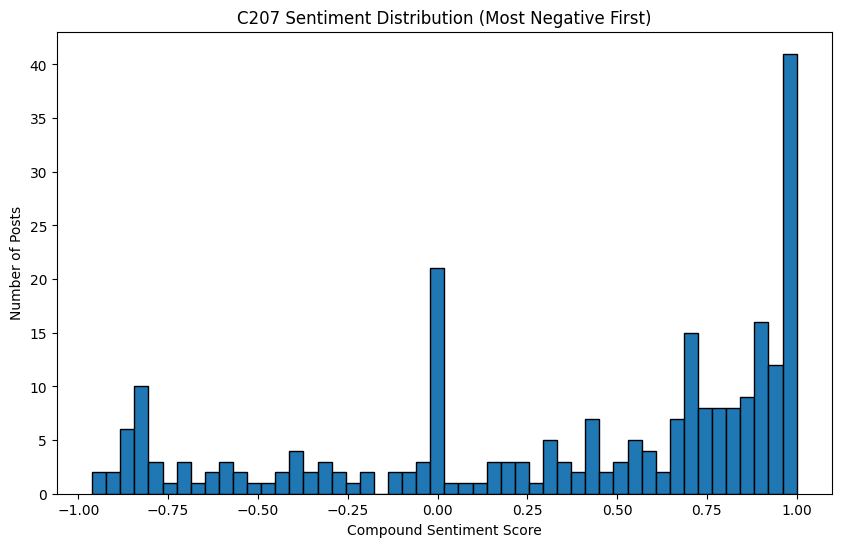

D316: 161 posts, min sentiment: -0.9485


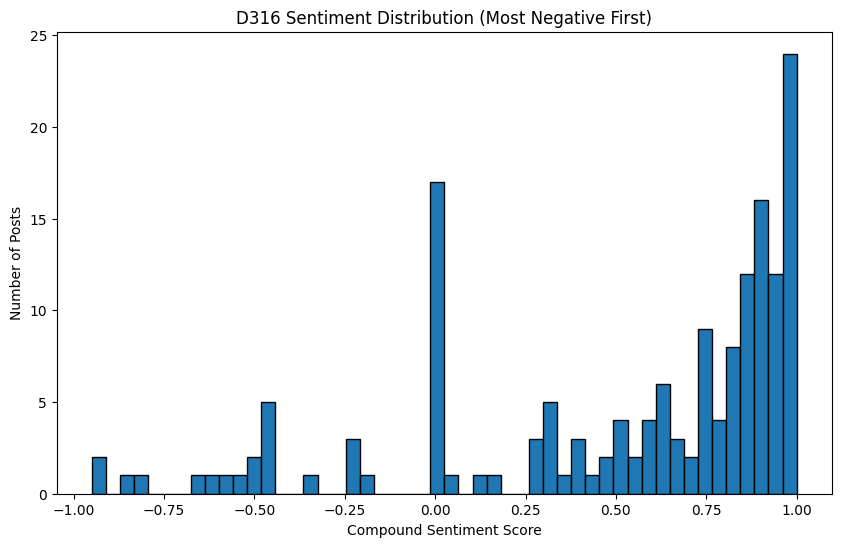

D487: 108 posts, min sentiment: -0.9475


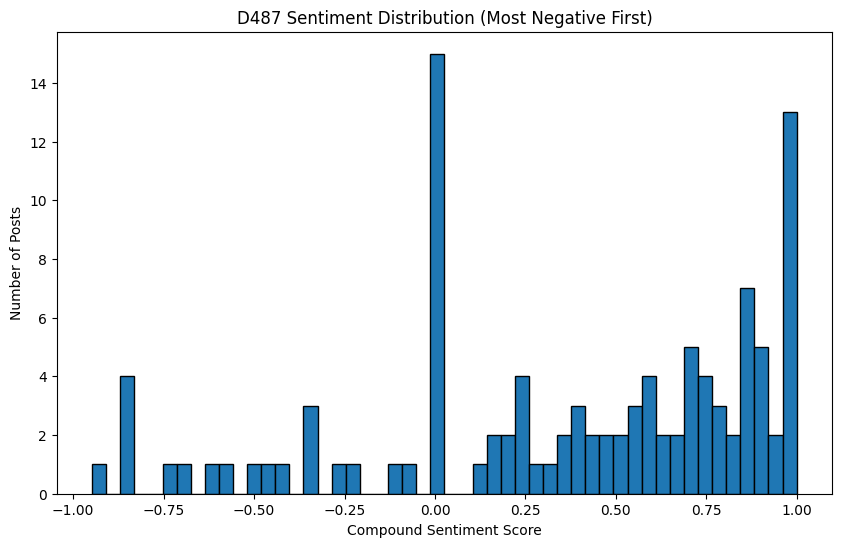

C211: 237 posts, min sentiment: -0.9371


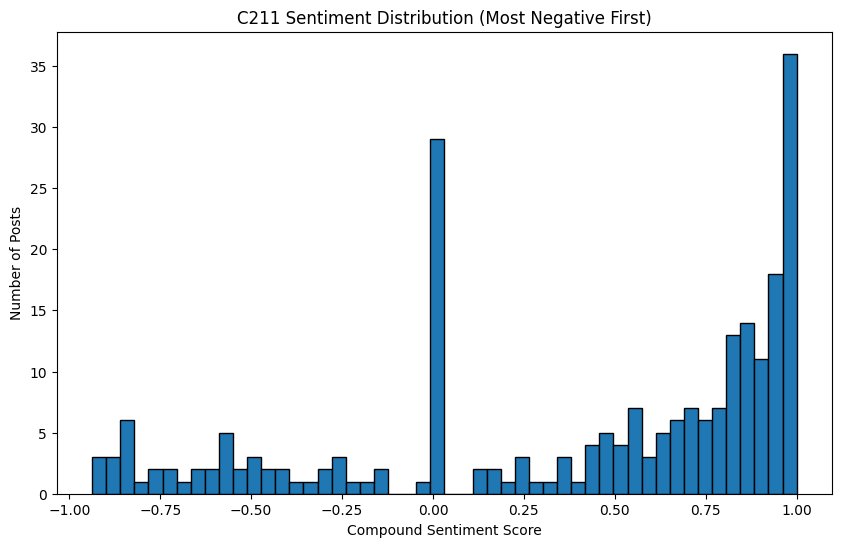

C215: 131 posts, min sentiment: -0.9297


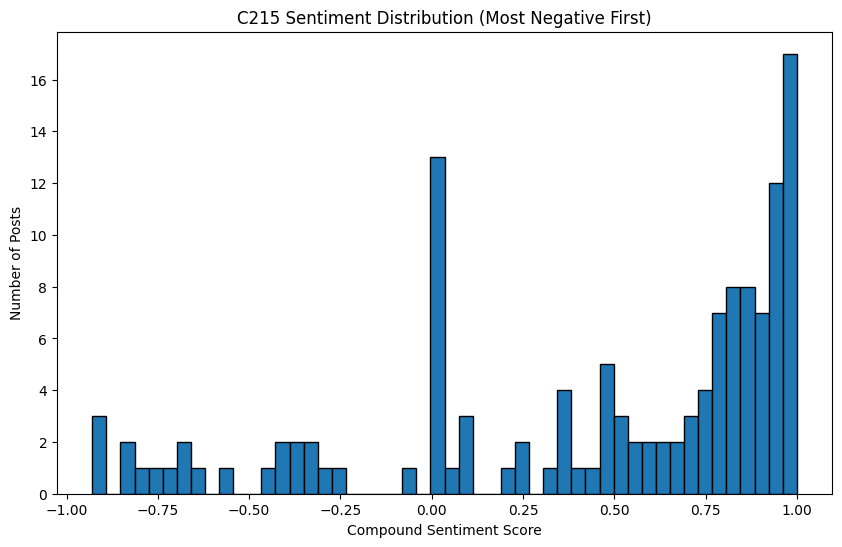

In [35]:
# show most negative first

# all_courses_sentiment_sorted.py

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from utils.paths import project_path

DB_PATH = project_path / "db/WGU-Reddit.db"
COURSES_CSV = "/Users/buddy/Desktop/WGU-Reddit/data/output/reddit_top_20_mentioned_courses.csv"

df_courses = pd.read_csv(COURSES_CSV)
course_codes = df_courses['Course Code'].tolist()

analyzer = SentimentIntensityAnalyzer()

# === Collect min sentiment per course ===
course_sentiments = []

for course_code in course_codes:
    conn = sqlite3.connect(DB_PATH)

    df_organic = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body'
        FROM posts
        WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
    """, conn, params=(course_code, course_code))

    df_keyword = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body'
        FROM posts_keyword
        WHERE search_terms = ?
    """, conn, params=(course_code,))

    conn.close()

    df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])
    df_combined['Title'] = df_combined['Title'].fillna('').str.strip()
    df_combined['Body'] = df_combined['Body'].fillna('').str.strip()
    df_clean = df_combined[(df_combined['Title'] != '') | (df_combined['Body'] != '')].copy()

    if df_clean.empty:
        course_sentiments.append((course_code, 0))  # neutral fallback
        continue

    def get_compound(row):
        text = f"{row['Title']} {row['Body']}"
        return analyzer.polarity_scores(text)['compound']

    df_clean['Sentiment'] = df_clean.apply(get_compound, axis=1)

    min_sentiment = df_clean['Sentiment'].min()
    course_sentiments.append((course_code, min_sentiment))

# === Sort by most negative ===
course_sentiments.sort(key=lambda x: x[1])

# === Plot in that order ===
for course_code, min_sentiment in course_sentiments:
    conn = sqlite3.connect(DB_PATH)

    df_organic = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body'
        FROM posts
        WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
    """, conn, params=(course_code, course_code))

    df_keyword = pd.read_sql_query("""
        SELECT post_id AS 'Post ID',
               title AS 'Title',
               selftext AS 'Body'
        FROM posts_keyword
        WHERE search_terms = ?
    """, conn, params=(course_code,))

    conn.close()

    df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])
    df_combined['Title'] = df_combined['Title'].fillna('').str.strip()
    df_combined['Body'] = df_combined['Body'].fillna('').str.strip()
    df_clean = df_combined[(df_combined['Title'] != '') | (df_combined['Body'] != '')].copy()

    if df_clean.empty:
        print(f"{course_code}: No posts.")
        continue

    df_clean['Sentiment'] = df_clean.apply(
        lambda row: analyzer.polarity_scores(f"{row['Title']} {row['Body']}")['compound'], axis=1
    )

    print(f"{course_code}: {len(df_clean)} posts, min sentiment: {min_sentiment}")

    plt.figure(figsize=(10, 6))
    plt.hist(df_clean['Sentiment'], bins=50, edgecolor='k')
    plt.title(f'{course_code} Sentiment Distribution (Most Negative First)')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Number of Posts')
    plt.show()

In [37]:
# show_negative_sentiment_posts_full_body.py

import sqlite3
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from utils.paths import project_path

# === CONFIG ===
COURSE_CODE = "D324"
DB_PATH = project_path / "db/WGU-Reddit.db"

# === LOAD ===
conn = sqlite3.connect(DB_PATH)

df_organic = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           title AS 'Title',
           selftext AS 'Body'
    FROM posts
    WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
""", conn, params=(COURSE_CODE, COURSE_CODE))

df_keyword = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           title AS 'Title',
           selftext AS 'Body'
    FROM posts_keyword
    WHERE search_terms = ?
""", conn, params=(COURSE_CODE,))

conn.close()

df_combined = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID'])
df_combined['Title'] = df_combined['Title'].fillna('').str.strip()
df_combined['Body'] = df_combined['Body'].fillna('').str.strip()
df_clean = df_combined[(df_combined['Title'] != '') | (df_combined['Body'] != '')].copy()

# === VADER ===
analyzer = SentimentIntensityAnalyzer()

def get_compound(row):
    text = f"{row['Title']} {row['Body']}"
    return analyzer.polarity_scores(text)['compound']

df_clean['Sentiment'] = df_clean.apply(get_compound, axis=1)

# === Filter negative ===
df_negative = df_clean[df_clean['Sentiment'] < 0].copy()
df_negative = df_negative[['Post ID', 'Title', 'Body', 'Sentiment']].sort_values(by='Sentiment')

pd.set_option('display.max_colwidth', None)

print(f"Negative posts for {COURSE_CODE}: {len(df_negative)}")
display(df_negative)

Negative posts for D324: 8


,Post ID,Title,Body,Sentiment
36,1b2wrgh,In Total Despair Over D324 (CompTIA Project+),"hi, I'm currently studying for the Project+. After completing both courses to get certified for A+ I was getting kind of excited that I'm starting to pick things up, but studying for Project+ has felt completely different. I'm completely overwhelmed with the amount of key terms. It might be just me, but figuring out Project+ has been a lot more difficult than the A+ courses. \n\nI'm a bit hopeless at this point. Part of that is my CompTiA exam failing to load after I checked in (i searched for the start button for over 2 hours at this point), and Support saying they're going to get back to me in a few days (unfortunately my semester will have ended by then, so I'm also scared about the penalty I'm going to get because I cannot afford to pay for it), but I genuinely feel like I wouldn't have passed it anyway.\n\nI've done Certmaster's exams, Dion's practice exams, and I watched CBT Nuggets for test prep, doing my research as I did for every other class on Reddit, but it feels...different. I'm scoring wild varying 40% to 60% to 75% depending on the place I take it and the questions I'm given. \n\nI'm having trouble memorizing all the charts and the methodologies, and then having to memorize each step of each methodology, and more. Every time I try to look at a practice exam or practice questions on a new website, I feel like there's another 5 things I didn't catch. It's just...not sticking with me at all. Is there a trick to the material I just haven't gotten yet? Is there a study group or someplace similar? \n\nSorry if this is kinda vent-y. bleh. It's been a few hours after my exam failed to start and I'm coping with the fact I wouldn't have passed anyway.",-0.9739
2,1kqhypm,Graduated in a Year 💪🏼 Ask Anything,"Did this while full time job as a chef, no kids, have a wifey.\n\nI transferred only one class, ITF+ to qualify because my GPA wasn’t good enough due to not caring in school.\n\nCareer changer from a chef of 7 years.\n\nI am now a SOC Analyst \n\nDid not have any prior experience, never even took an IT class in High School.\n\nWorked my ass off for this, and WGU has changed my life because of it.\n\nDid not get a help desk job, don’t listen to these fear mongers, it’s possible to get into cybersecurity and you can do it.\n\nApply yourself, how bad do you actually want this? I slept on the floor daily for 20 minutes to increase study time due to only sleeping 5 hours a night.\n\nStarted work at 4am, done by 12pm, and dedicated all other time to studying and family time and gym (don’t neglect this).\n\nI received an extension for my capstone only because cause I believe my previous classwork was done the way I did it, they could see I actually tried.",-0.8953
19,1efi8wo,"How difficult are C845, D324, D334?","I am trying to get a plan together for the rest of my semester to avoid some upcoming time constrained months . I wanted to take the most difficult class in August, so September/October I can have time to deal with other stuff and take a simpler course. So was wondering how people ranked C845 (Information Systems Security), D324 (Busines of IT - Project Management), D334 (Introduction to Cryptography).",-0.6697
13,191qzx8,Passed D324 Business of I.T Project Management,"I barely passed. I got 715 and you only need 710 to pass.\n\nStudy sources :\nDion's exams \n\nCertmaster Learn and practice \n\nThe day before the exam I read half of Project + Pko-005 Study Guide by Kim Heldman \n\nMy assessment of the exam \nI thought the exam questions were going to straightforward, but some of were vague as hell.\n\nI don't really have any good tips for this exam other than read the questions throughly",-0.5796
39,19chsla,D324 - Project+,Which practice exam is closest to the actual exam? \nCertmaster? CyberVista? Other?\n\nI've done the CyberVista practice exam so far and found it difficult and rushed (90 ques in 90 minutes) and do have experien

In [42]:
# Filename: subreddit_post_counts_D324.py

import sqlite3
import pandas as pd
from utils.paths import project_path

# === CONFIG ===
COURSE_CODE = "D324"
DB_PATH = project_path / "db/WGU-Reddit.db"

# === LOAD ===
conn = sqlite3.connect(DB_PATH)

df_organic = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           subreddit_id AS 'Subreddit ID'
    FROM posts
    WHERE instr(title, ?) > 0 OR instr(selftext, ?) > 0
""", conn, params=(COURSE_CODE, COURSE_CODE))

df_keyword = pd.read_sql_query("""
    SELECT post_id AS 'Post ID',
           subreddit_id AS 'Subreddit ID'
    FROM posts_keyword
    WHERE search_terms = ?
""", conn, params=(COURSE_CODE,))

df_subreddits = pd.read_sql_query("""
    SELECT subreddit_id AS 'Subreddit ID',
           name AS 'Subreddit'
    FROM subreddits
""", conn)

conn.close()

df = pd.concat([df_organic, df_keyword]).drop_duplicates(subset=['Post ID']).merge(
    df_subreddits, on='Subreddit ID', how='left'
)

df_counts = df.groupby('Subreddit').size().reset_index(name='Total D324 Posts').sort_values(
    by='Total D324 Posts', ascending=False
)

print(f"Post counts for {COURSE_CODE} by subreddit:\n")
print(df_counts.to_string(index=False))

Post counts for D324 by subreddit:

       Subreddit  Total D324 Posts
             WGU                63
        wgu_devs                17
           WGUIT                11
WGUCyberSecurity                10
WGU_Accelerators                 2
         WGU_CSA                 1
    WGU_Military                 1


## get age of keyword fetched posts

Min days old: 2.11
Max days old: 3755.79


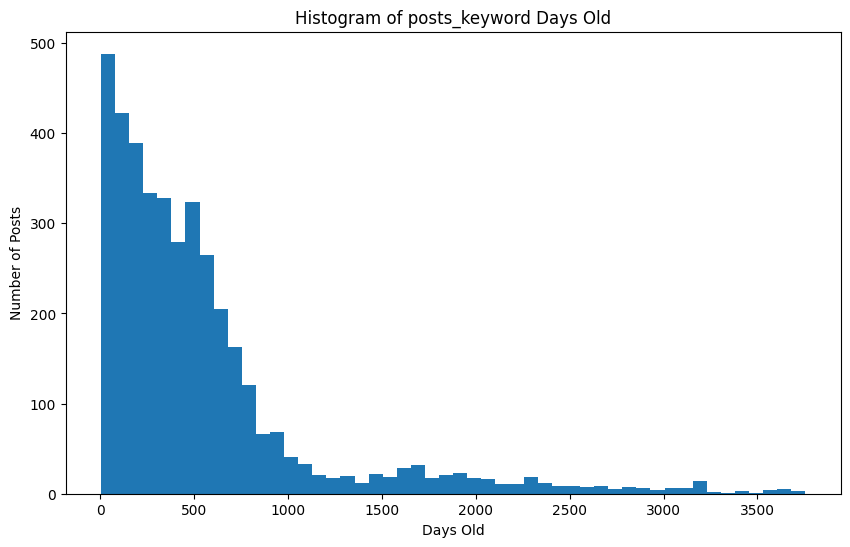

In [44]:
# inspect_posts_keyword_days_old.py

import sqlite3
import matplotlib.pyplot as plt
import time

# Connect to the DB
conn = sqlite3.connect("/Users/buddy/Desktop/WGU-Reddit/db/WGU-Reddit.db")
cur = conn.cursor()

# Get all created_utc timestamps
cur.execute("SELECT created_utc FROM posts_keyword")
timestamps = [row[0] for row in cur.fetchall()]

conn.close()

# Current time in UTC
now = int(time.time())

# Convert to days old
days_old = [(now - ts) / 86400 for ts in timestamps]

print(f"Min days old: {min(days_old):.2f}")
print(f"Max days old: {max(days_old):.2f}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(days_old, bins=50)
plt.title("Histogram of posts_keyword Days Old")
plt.xlabel("Days Old")
plt.ylabel("Number of Posts")
plt.show()